In [54]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import models
from keras import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.metrics import AUC
from keras.regularizers import L1

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup 
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SergS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SergS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SergS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
colnames=['ID', 'Social network', 'Sentiment', 'Text'] 

In [3]:
df_train = pd.read_csv('twitter_training.csv', names=colnames, header=None)

In [4]:
df_val = pd.read_csv('twitter_validation.csv', names=colnames, header=None)

In [5]:
df_train.head(2)

,ID,Social network,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...


In [9]:
df_val.head(2)

,ID,Social network,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              74682 non-null  int64 
 1   Social network  74682 non-null  object
 2   Sentiment       74682 non-null  object
 3   Text            73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              1000 non-null   int64 
 1   Social network  1000 non-null   object
 2   Sentiment       1000 non-null   object
 3   Text            1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [6]:
df_train = df_train.replace(to_replace='None', value=np.nan).dropna()

In [14]:
print("__________TRAIN__________")
print(f"Count of categories: {len(df_train['Sentiment'].unique())}")
print(f"Categories names: {df_train['Sentiment'].unique()}")
print(f"Categories values counts:\n{df_train['Sentiment'].value_counts()}")
print("\n________VALIDATION________")
print(f"Count of categories: {len(df_val['Sentiment'].unique())}")
print(f"Categories names: {df_val['Sentiment'].unique()}")
print(f"Categories values counts:\n{df_val['Sentiment'].value_counts()}")

__________TRAIN__________
Count of categories: 4
Categories names: ['Positive' 'Neutral' 'Negative' 'Irrelevant']
Categories values counts:
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: Sentiment, dtype: int64

________VALIDATION________
Count of categories: 4
Categories names: ['Irrelevant' 'Neutral' 'Negative' 'Positive']
Categories values counts:
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: Sentiment, dtype: int64


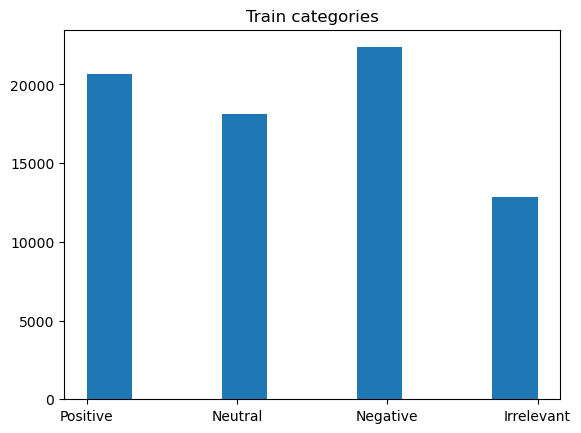

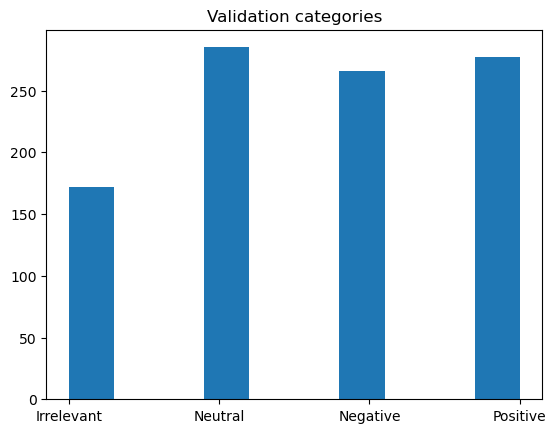

In [15]:
plt.hist(df_train['Sentiment'])
plt.title("Train categories")
plt.show()

plt.hist(df_val['Sentiment'])
plt.title("Validation categories")
plt.show()

In [9]:
def cleaned_review(review):
  stop = stopwords.words("english")
  stop.remove('not')
  stop.remove('no')
  
  lemmatizer = WordNetLemmatizer()
  # убираем теги html
  new_review = BeautifulSoup(review).get_text()
  # убираем url
  no_urls = new_review.replace('http\S+', '').replace('www\S+', '')
  # убираем символы кроме букв
  clean_review = re.sub("[^a-zA-Z]", " ", no_urls)
  # приводим в нижнему регистру
  new_words = clean_review.lower().split()
  # лематизируем и убираем стоп-слова
  final_words = [lemmatizer.lemmatize(word) for word in new_words if not word in stop]
    
  return (" ".join(final_words))

In [10]:
df_train['Text'] = df_train['Text'].apply(lambda x:cleaned_review(x))

c:\Users\SergS\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [11]:
df_val['Text'] = df_val['Text'].apply(lambda x:cleaned_review(x))

In [37]:
train_data = df_train['Text'].to_list()
val_data = df_val['Text'].to_list()
train_data = np.concatenate([train_data, val_data])

In [38]:
train_categ = df_train['Sentiment']
val_categ = df_val['Sentiment']

In [39]:
labels = list(df_train['Sentiment'].unique())
label2id = {v:k for k,v in enumerate(labels)}
print(labels)
print(label2id)

['Positive', 'Neutral', 'Negative', 'Irrelevant']
{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}


In [40]:
train_targets = np.array(df_train["Sentiment"].map(label2id).to_list())
val_targets = np.array(df_val['Sentiment'].map(label2id).to_list())
train_targets = np.concatenate([train_targets, val_targets])

In [41]:
max_len = 128   # отсечение остатка отзывов после 500-го слова
max_words = 27191     # рассмотрение только 10_000 наиболее часто используемых слов

tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # создаем токенайзер
vocab = tokenizer.fit_on_texts(train_data)   # создаем словарь на основе слов из текста 
sequences = tokenizer.texts_to_sequences(train_data) # преобразуем каждый текст в последовательность чисел

In [42]:
word_index = tokenizer.word_index   # получаем количество уникальных слов
print('Found %s unique tokens'%len(word_index))

Found 27192 unique tokens


In [43]:
train_texts = pad_sequences(sequences, maxlen=max_len)   # преобразуем в массив numpy размером (num_samples, max_len)

In [44]:
print(train_targets.shape)

(74996,)


In [45]:
indices = np.arange(train_targets.shape[0])    # перемешиваем данные
np.random.shuffle(indices)
train_texts = train_texts[indices]
train_targets = train_targets[indices]
# train test split
test_texts = train_texts[:10_000]
test_targets = train_targets[:10_000]

train_texts = train_texts[10_000:]
train_targets = train_targets[10_000:]

In [46]:
train_targets = to_categorical(train_targets)
test_targets = to_categorical(test_targets)

In [47]:
print(f"Train texts shape: {train_texts.shape}")
print(f"Test texts shape: {test_texts.shape}")

Train texts shape: (64996, 128)
Test texts shape: (10000, 128)


In [48]:
print(f"Train targets shape: {train_targets.shape}")
print(f"Test targets shape: {test_targets.shape}")

Train targets shape: (64996, 4)
Test targets shape: (10000, 4)


27191

In [49]:


# Гиперпараметры
vocab_size = max_words  # Размер словаря
embedding_dim = 128  # Размерность эмбеддинга
max_length = 128  # Максимальная длина входной последовательности
num_classes = 4  # Количество классов для классификации
num_heads = 8  # Количество головок внимания
num_filters = 64  # Количество фильтров в сверточном слое

# Слои модели
input_layer = layers.Input(shape=(max_length,))
embedding_layer = layers.Embedding(vocab_size, embedding_dim)(input_layer)

# Conv2D слой
conv_layer = layers.Conv1D(num_filters, 3, activation='relu', padding='same')(embedding_layer)
conv_layer = layers.MaxPooling1D(pool_size=2)(conv_layer)

# Multi-head attention слой (ЭТО МОЖНО УДАЛИТЬ)
query = layers.Dense(embedding_dim)(conv_layer)
key = layers.Dense(embedding_dim)(conv_layer)
value = layers.Dense(embedding_dim)(conv_layer)
print(query.shape)
attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(query, key, value)
attention_output = layers.GlobalAveragePooling1D()(attention_output)

# Полносвязный слой и выходной слой
dense_layer = layers.Dense(64, activation='relu')(attention_output)
output_layer = layers.Dense(num_classes, activation='softmax')(dense_layer)

# Создание и компиляция модели
model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

(None, 64, 128)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 128, 128)     3480448     ['input_2[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 128, 64)      24640       ['embedding_1[0][0]']            
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 64, 64)      0           ['conv1d_1[0][0]']               
                                                                            

In [50]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [60]:
# checkpoint = ModelCheckpoint(filepath='best_attention.h5', save_best_only = True, monitor='val_loss')
# lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)
es_callback = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=['acc', AUC()])

In [ ]:

history = model.fit(train_texts, train_targets, epochs=100, validation_split=0.2, batch_size=256, callbacks=[es_callback])
model.save('best_attention.h5')

In [62]:
model = tf.keras.models.load_model("best_attention.h5")

In [63]:
model.evaluate(test_texts, test_targets)

313/313 [==============================] - 3s 7ms/step - loss: 0.5119 - acc: 0.8764 - auc_2: 0.9703


[0.5118789076805115, 0.8763999938964844, 0.9703169465065002]